In [1]:
# 5. Import the required modules

import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

import os
import networkx as nx
import nx_arangodb as nxadb

# os.environ["DATABASE_HOST"] = "https://b61c3b83bfe6.arangodb.cloud:8529"
# os.environ["DATABASE_USERNAME"] = "root"
# os.environ["DATABASE_PASSWORD"] = "RHr0KzkRUVlp61IisH8G"
# os.environ["DATABASE_NAME"] = "DAC_devops_log"

db = ArangoClient(hosts="https://b61c3b83bfe6.arangodb.cloud:8529") \
    .db(username="root", 
        password="RHr0KzkRUVlp61IisH8G", 
        name="DAC_devops_log",
        verify=True)

[03:42:22 -0500] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


## 1. load data

In [2]:
arango_graph = ArangoGraph(db)
# G_adb = nxadb.DiGraph(name="emp_interaction1")

In [3]:
task = pd.read_csv('../data/tasks.csv')

# Split the comma-separated values into lists
task['AssignedEmployees'] = task['AssignedEmployees'].str.split(',')
task['Advisors'] = task['Advisors'].str.split(',')

# Explode the lists into separate rows
task_exploded = task.explode('AssignedEmployees').explode('Advisors', ignore_index=True)

# Show the exploded DataFrame
edge_emp = task_exploded[['AssignedEmployees', 'Advisors']]

In [4]:
node_emp = pd.read_csv('../data/employees.csv')

In [5]:
G = nx.from_pandas_edgelist(edge_emp, "Advisors", "AssignedEmployees")
print(G)

Graph with 36 nodes and 235 edges


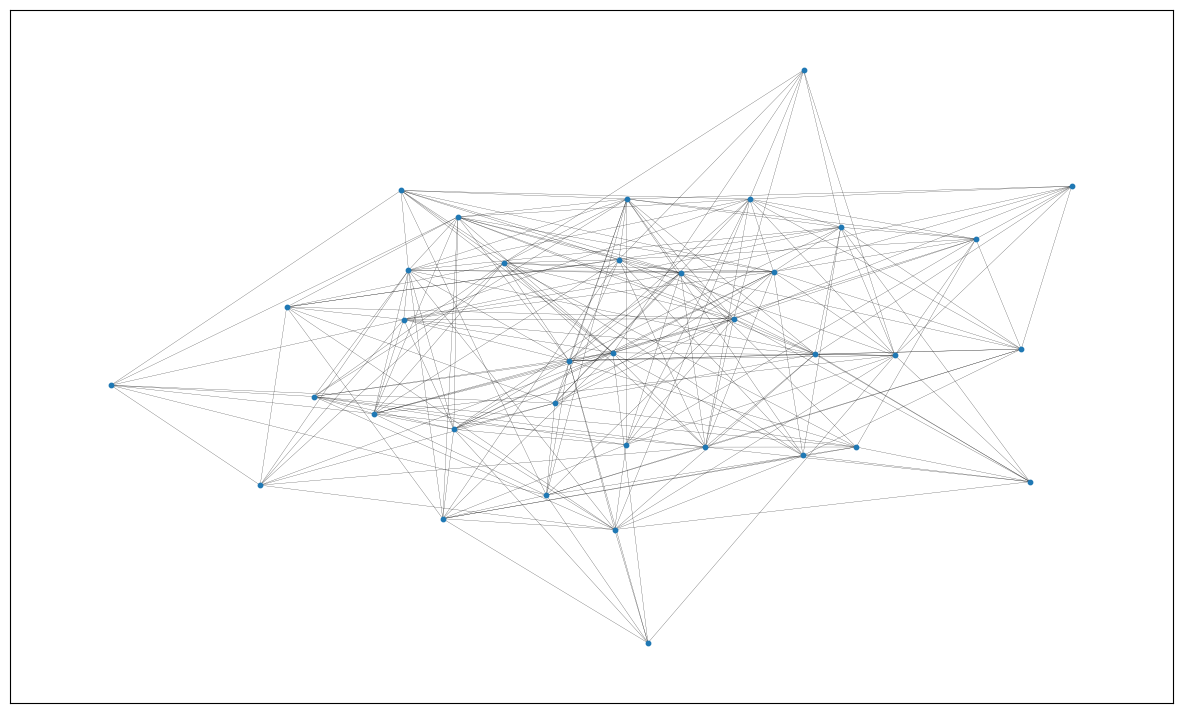

In [6]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [7]:
G_adb = nxadb.DiGraph(
    name="emp_interaction1",
    db=db,
    incoming_graph_data=G,
    overwrite_graph=True,
    write_batch_size=50000 # feel free to modify
)

print(G_adb)

[03:42:34 -0500] [INFO]: Overwriting graph 'emp_interaction1'
[03:42:35 -0500] [INFO]: Graph 'emp_interaction1' exists.
[03:42:35 -0500] [INFO]: Default node type set to 'emp_interaction1_node'
[2025/03/08 03:42:36 -0500] [74795] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'DAC_devops_log'


Output()

Output()

[2025/03/08 03:42:37 -0500] [74795] [INFO] - adbnx_adapter: Created ArangoDB 'emp_interaction1' Graph


DiGraph named 'emp_interaction1' with 36 nodes and 235 edges


## 2. hits

In [8]:
G_adb = nxadb.DiGraph(name="emp_interaction1", db=db)

[03:42:38 -0500] [INFO]: Graph 'emp_interaction1' exists.
[03:42:38 -0500] [INFO]: Default node type set to 'emp_interaction1_node'


In [9]:
@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return FINAL_RESULT, nx_to_text


In [10]:
text_to_nx_algorithm_to_text('Perform hits algorithm on my graph')

/var/folders/0y/xnx3sz6927z6fg600l0yk8p40000gn/T/ipykernel_74795/2790549570.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  text_to_nx_algorithm_to_text('Perform hits algorithm on my graph')


1) Generating NetworkX code
----------
import networkx as nx

# Assuming G_adb is already defined and is a NetworkX graph object

# Perform the HITS algorithm on the graph
hubs, authorities = nx.hits(G_adb)

# Store the result in FINAL_RESULT
FINAL_RESULT = (hubs, authorities)
----------

2) Executing NetworkX code


[03:42:43 -0500] [INFO]: Graph 'emp_interaction1' load took 2.6228599548339844s


----------
FINAL_RESULT: ({'emp_interaction1_node/30': 0.016278760660845257, 'emp_interaction1_node/29': 0.013253608974219601, 'emp_interaction1_node/22': 0.016140732863048495, 'emp_interaction1_node/3': 0.04263623261612163, 'emp_interaction1_node/15': 0.012676984075128633, 'emp_interaction1_node/16': 0.01195624522964811, 'emp_interaction1_node/13': 0.03607180001704574, 'emp_interaction1_node/19': 0.0366344424988705, 'emp_interaction1_node/26': 0.02968591199291798, 'emp_interaction1_node/0': 0.061461925906224235, 'emp_interaction1_node/32': -0.0, 'emp_interaction1_node/4': 0.04768606963393216, 'emp_interaction1_node/24': 0.022748139541730085, 'emp_interaction1_node/17': 0.03205438668744799, 'emp_interaction1_node/6': 0.0478716099818063, 'emp_interaction1_node/14': 0.02602754443589863, 'emp_interaction1_node/33': 0.0030967557497602397, 'emp_interaction1_node/1': 0.05876224688399998, 'emp_interaction1_node/5': 0.024443451372233162, 'emp_interaction1_node/31': -0.0, 'emp_interaction1_node

(({'emp_interaction1_node/30': 0.016278760660845257,
   'emp_interaction1_node/29': 0.013253608974219601,
   'emp_interaction1_node/22': 0.016140732863048495,
   'emp_interaction1_node/3': 0.04263623261612163,
   'emp_interaction1_node/15': 0.012676984075128633,
   'emp_interaction1_node/16': 0.01195624522964811,
   'emp_interaction1_node/13': 0.03607180001704574,
   'emp_interaction1_node/19': 0.0366344424988705,
   'emp_interaction1_node/26': 0.02968591199291798,
   'emp_interaction1_node/0': 0.061461925906224235,
   'emp_interaction1_node/32': -0.0,
   'emp_interaction1_node/4': 0.04768606963393216,
   'emp_interaction1_node/24': 0.022748139541730085,
   'emp_interaction1_node/17': 0.03205438668744799,
   'emp_interaction1_node/6': 0.0478716099818063,
   'emp_interaction1_node/14': 0.02602754443589863,
   'emp_interaction1_node/33': 0.0030967557497602397,
   'emp_interaction1_node/1': 0.05876224688399998,
   'emp_interaction1_node/5': 0.024443451372233162,
   'emp_interaction1_node/

In [11]:
# Run the HITS algorithm
hubs, authorities = nx.hits(G_adb)

# Print the results for hubs and authorities
print("Hubs:", hubs)
print("Authorities:", authorities)

[03:42:49 -0500] [INFO]: Graph 'emp_interaction1' load took 2.451594829559326s


Hubs: {'emp_interaction1_node/4': 0.047686069633932154, 'emp_interaction1_node/13': 0.036071800017045734, 'emp_interaction1_node/2': 0.04971262784125719, 'emp_interaction1_node/1': 0.05876224688399998, 'emp_interaction1_node/19': 0.0366344424988705, 'emp_interaction1_node/32': -0.0, 'emp_interaction1_node/0': 0.06146192590622424, 'emp_interaction1_node/15': 0.01267698407512863, 'emp_interaction1_node/30': 0.01627876066084526, 'emp_interaction1_node/11': 0.026511995235377825, 'emp_interaction1_node/16': 0.011956245229648112, 'emp_interaction1_node/8': 0.04971327487449613, 'emp_interaction1_node/24': 0.02274813954173008, 'emp_interaction1_node/6': 0.04787160998180632, 'emp_interaction1_node/3': 0.04263623261612162, 'emp_interaction1_node/10': 0.03647225570435452, 'emp_interaction1_node/14': 0.026027544435898633, 'emp_interaction1_node/33': 0.0030967557497602392, 'emp_interaction1_node/28': 0.01286092452778889, 'emp_interaction1_node/26': 0.02968591199291798, 'emp_interaction1_node/18': 0

In [12]:
import pandas as pd

# Create a DataFrame from hubs and authorities
hits_df = pd.DataFrame({
    'Node': list(hubs.keys()),
    'Hub_Score': list(hubs.values()),
    'Authority_Score': list(authorities.values())
})

# Clean the Node column by removing 'emp_interaction1_node/'
hits_df['Node'] = hits_df['Node'].str.replace('emp_interaction1_node/', '')

# Sort by Hub Score in descending order
hits_df = hits_df.sort_values('Hub_Score', ascending=False)

# Reset the index
hits_df = hits_df.reset_index(drop=True)

# Display the DataFrame
print("\nCombined HITS Scores:")
display(hits_df)


Combined HITS Scores:


,Node,Hub_Score,Authority_Score
0,0,0.061462,7.040450e-19
1,1,0.058762,6.629971e-03
2,9,0.055764,2.347531e-02
3,8,0.049713,1.909731e-02
4,2,0.049713,1.296872e-02
5,6,0.047872,1.811268e-02
6,4,0.047686,1.659175e-02
7,7,0.043261,1.179394e-02
8,3,0.042636,1.199253e-02
9,20,0.039491,2.062369e-02


In [13]:
# Optionally, you can rank the nodes based on their hub and authority scores:
sorted_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)
sorted_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)

# Print the sorted hubs and authorities
print("Sorted Hubs (Top 5):", sorted_hubs[:5])
print("Sorted Authorities (Top 5):", sorted_authorities[:5])

# # You can also add the hub and authority scores as attributes to the nodes
# for node in G_adb.nodes:
#     G_adb.nodes[node]['hub'] = hubs.get(node, 0)
#     G_adb.nodes[node]['authority'] = authorities.get(node, 0)

# # If you want to push the updated graph back to ArangoDB
# G_adb.push()

Sorted Hubs (Top 5): [('emp_interaction1_node/0', 0.06146192590622424), ('emp_interaction1_node/1', 0.05876224688399998), ('emp_interaction1_node/9', 0.055764341861230166), ('emp_interaction1_node/8', 0.04971327487449613), ('emp_interaction1_node/2', 0.04971262784125719)]
Sorted Authorities (Top 5): [('emp_interaction1_node/27', 0.06270266266466548), ('emp_interaction1_node/31', 0.06054869503280942), ('emp_interaction1_node/30', 0.05356930078357237), ('emp_interaction1_node/25', 0.04644592636010523), ('emp_interaction1_node/18', 0.045073055915790326)]


In [14]:
# # Optional: View a specific node's hub and authority score
# node_id = "some_node_id"  # Replace with a valid node ID
# print(f"Hub score for {node_id}: {G_adb.nodes[node_id].get('hub', 0)}")
# print(f"Authority score for {node_id}: {G_adb.nodes[node_id].get('authority', 0)}")